# Test 3 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

**Idée :** On se place ici dans un des cas tests proposés.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem_3D import FEMSolver
from modules.utils import create_tree
from modules.fenics_expressions import UexExpr

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [4]:
if testcase == 1:
    from modules.testcases.test_1_3D import Run_laplacian3D,Poisson_3D
    
    # if version == 1:
    #     from modules.testcases.test_1 import Run_laplacian2D,Poisson_2D
    # elif version == 2:
    #     from modules.testcases.test_1_v2 import Run_laplacian2D,Poisson_2D
    # else:
    #     raise ValueError("Version not found")
    from modules.problem_3D import TestCase1_3D
    problem = TestCase1_3D()
# elif testcase == 2:
#     from modules.testcases.test_2 import Run_laplacian2D,Poisson_2D
#     from modules.problem import TestCase2
#     problem = TestCase2()
else:
    raise ValueError("Testcase not found")

result_dir = "../results/testcase"+str(testcase)+"_3D"
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cuda


>> load network /home/flecourtier/Bureau/Article1/networks/test_fe1_3D.pth
jsbdbshd
network loaded


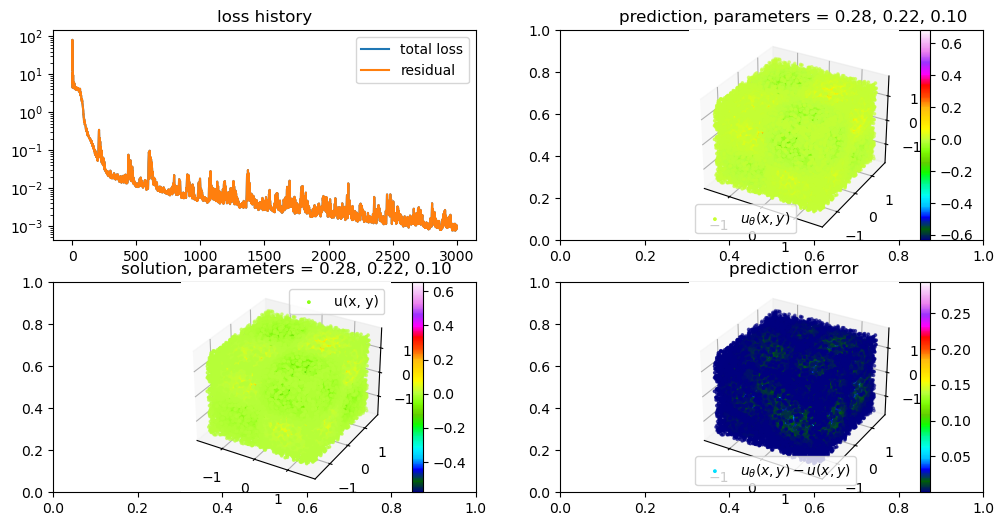

 >>> 2.6170477867126465


In [5]:
pde = Poisson_3D()
trainer,u_theta = Run_laplacian3D(pde)

In [6]:
def get_param(i):
    params = problem.parameter_domain
    # params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1]), np.random.uniform(params[2][0], params[2][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22 0.1 ]


## Convergence PINNs+Corr

In [7]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [10]:
degree_PINNs = 3

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [20]
        # tab_nb_vert_Corr = [5*i for i in range(2,7)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            tab_h_Corr.append(solver.h)
            
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            u_ex = UexExpr(params[0], degree=solver.high_degree, domain=solver.mesh, pb_considered=solver.pb_considered)
                
            uref_Vex = df.interpolate(u_ex,V_test)
            norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
        
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [11]:
degree = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(degree,new_run=True)

Time to generate mesh:  0.0012462139129638672
hmax =  0.28638937330014047
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time to assemble the matrix :  29.39550232887268
Time to solve the system : 0.09812664985656738
nb_vert=20, norme_L2=0.024021955537141718


In [ ]:
# plt.figure(figsize=(5, 5))

# # plot Corr error (L2 norm) as a function of h
# for d in [1, 2, 3]:
#     print(f"degree={d}")
#     df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d,new_run=True)
#     plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
#     # add slope with a triangle
#     start = [tab_nb_vert_Corr[1],tab_err_Corr[1]]
#     end = [tab_nb_vert_Corr[0],tab_err_Corr[0]]
#     third = [end[0],start[1]]
    
#     tri_x = [end[0], third[0], start[0], end[0]]
#     tri_y = [end[1], third[1], start[1], end[1]]
#     plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
#     slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
#     slope = abs(int(slope.round(0)))

#     vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
#     plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

# plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
# plt.xlabel("nb_vert")
# plt.ylabel('L2 norm')
# plt.legend()
# plt.title(f'Corr case{testcase} param{param_num} : {param}')
# plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

degree=1


ValueError: Geometry not implemented

<Figure size 500x500 with 0 Axes>

In [14]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../results/testcase2/cvg/Corr_case2_param2_degree1.csv
degree=2
Read csv file ../results/testcase2/cvg/Corr_case2_param2_degree2.csv
degree=3
Read csv file ../results/testcase2/cvg/Corr_case2_param2_degree3.csv


## Plots

degree=1
Read csv file ../results/testcase2/cvg/FEM_case2_param2_degree1.csv
degree=2
Read csv file ../results/testcase2/cvg/FEM_case2_param2_degree2.csv
degree=3
Read csv file ../results/testcase2/cvg/FEM_case2_param2_degree3.csv
degree=1
Read csv file ../results/testcase2/cvg/Corr_case2_param2_degree1.csv
degree=2
Read csv file ../results/testcase2/cvg/Corr_case2_param2_degree2.csv
degree=3
Read csv file ../results/testcase2/cvg/Corr_case2_param2_degree3.csv


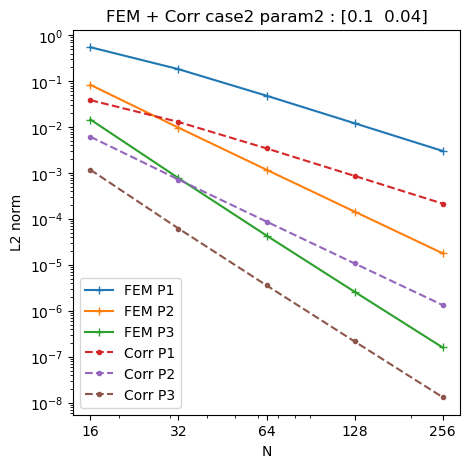

In [15]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')